# Feature variation in word replacement chunks

## 1 Setup

Flags

In [28]:
SAVE_FIGURES = True
STOPWORDS = 'exclude'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter
import itertools
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats, spatial
import seaborn as sb
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar
from nltk.corpus import wordnet

from gists.models import Sentence, Tree

from analysis.utils import quantile_interval, pairwise, get_nlp
from analysis.features import PoolError

sb.set()
sb.set_style('whitegrid')
blue, green, red, purple, yellow, cyan = sb.color_palette()
nlp = get_nlp()

## 2 Feature variation

### 2.1 Setup

We need a few helper functions first

In [4]:
def additional_features(parent, child):
    return {
        'token_length': len(parent.tokens),
        'content_length': len(parent.content_tokens),
    }

def base(parent, child):
    return {
        # indices
        'tree_id': parent.tree.id,
        'parent_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
    }

def final_feature_name(feature, rel):
    return feature + (('-rel' + rel) if rel is not None else '')

def hypernym_rate(parent_lemma, child_lemma):
    parent_synsets = wordnet.synsets(parent_lemma)
    child_synsets = wordnet.synsets(child_lemma)
    hypernym_count = 0
    hyponym_count = 0
    for parent_synset in parent_synsets:
        for child_synset in child_synsets:
            parent_paths = parent_synset.hypernym_paths()
            child_paths = child_synset.hypernym_paths()
            hypernym_count += np.mean([child_synset in p for p in parent_paths])
            hyponym_count += np.mean([parent_synset in p for p in child_paths])
    
    if hypernym_count == 0 and hyponym_count == 0:
        return np.nan
    else:
        return hypernym_count / (hypernym_count + hyponym_count)
                
def rows(parent, child, feature, rel=None):
    STOPWORDS_nan = Sentence._SW_NAN if STOPWORDS == Sentence._SW_EXCLUDE else STOPWORDS
    parent_values = parent.features(feature, rel=rel, stopwords=STOPWORDS_nan)
    child_values = child.features(feature, rel=rel, stopwords=STOPWORDS_nan)
    _, _, rpl_pairs, _ = parent.consensus_relationships(child)

    for (parent_id, child_id) in rpl_pairs:
        # Get the values' quantile position.
        parent_start_quantile, parent_stop_quantile = quantile_interval(parent_values, parent_values[parent_id])
        child_start_quantile, child_stop_quantile = quantile_interval(child_values, child_values[child_id])
        
        # Get h0 if possible (h0n will never fail)
        try:
            h0 = parent.token_average(parent_id, feature, rel=rel, stopwords=STOPWORDS_nan)
        except PoolError:
            h0 = np.nan

        parent_token = parent.tokens[parent_id]
        child_token = child.tokens[child_id]
        # Compute feature-independent things only once
        if feature == 'aoa':
            # Get the distance between parent and child tokens
            if (parent_token.has_vector and child_token.has_vector and
                    (STOPWORDS == Sentence._SW_INCLUDE or (parent_id in parent.content_ids
                                                           and child_id in child.content_ids))):
                # Both words are stopword-accepted, and have vectors
                distance = spatial.distance.cosine(parent_token.vector, child_token.vector)
                distances_h0n = []
                for syn in Sentence._strict_synonyms(parent_token.lemma_):
                    nlp_syn = nlp(syn)[0]
                    if nlp_syn.has_vector:
                        distances_h0n.append(spatial.distance.cosine(parent_token.vector, nlp_syn.vector))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', category=RuntimeWarning)
                    distance_h0n = np.mean(distances_h0n)
            else:
                distance = np.nan
                distance_h0n = np.nan
            
            # Get hypernym relationship and rate
            h_rate = hypernym_rate(parent_token.lemma_, child_token.lemma_)
            h_related = not np.isnan(h_rate)
        else:
            distance = np.nan
            distance_h0n = np.nan
            h_rate = np.nan
            h_related = np.nan
            h_rate_h0n = np.nan
            h_related_h0n = np.nan
        
        row = base(parent, child)
        row.update(additional_features(parent, child))
        row.update({
            'feature': final_feature_name(feature, rel),
            'parent_value': parent_values[parent_id],
            'child_value': child_values[child_id],
            'parent_pos': parent_token.pos,
            'child_pos': child_token.pos,
            'distance': distance,
            'distance_h0n': distance_h0n,
            'hypernym_rate': h_rate,
            'hypernym_related': h_related,
            'parent_start_quantile': parent_start_quantile,
            'parent_stop_quantile': parent_stop_quantile,
            'child_start_quantile': child_start_quantile,
            'child_stop_quantile': child_stop_quantile,
            'h0': h0,
            'h0n': parent.token_average(parent_id, feature, rel=rel, stopwords=STOPWORDS_nan,
                                        restrict_synonyms=True),
        })
        # TODO for verbs/nouns/adj-verb: add POS, parent-child distance, h0n distance (avg of synonyms)
        yield row

Now build the master DataFrame that we plot below

In [5]:
features = sorted(set(Sentence.WORD_FEATURES.keys())
                  .difference(['depth_under', 'depth_above',
                               'depth_prop', 'depth_subtree_prop',
                               'sentence_prop']))
features_rel = list(map(lambda f: final_feature_name(f, 'mean'), features))
paper_features = ['zipf_frequency', 'aoa', 'clustering', 'letters_count']

data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    # Clean up before each tree, or else memory usage explodes
    analysis.utils.Memoize.drop_caches()
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(head.branch_sentences(with_root=True, with_leaf=True)):
        
            for feature in features:
                for row in rows(parent, child, feature, rel=None):
                    data.append(row)
                for row in rows(parent, child, feature, rel='mean'):
                    data.append(row)

data = pd.DataFrame(data)
index = sorted(set(data.columns).difference(['value', 'feature']))

100% (50 of 50) |#########################| Elapsed Time: 0:17:27 Time: 0:17:27


Average accordingly

In [6]:
variations = data.groupby(['child_id', 'feature'], as_index=False).mean()

Set up some plotting functions

In [7]:
def plot_variation(**kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', blue)
    quantiles = kwargs.get('quantiles', False)
    binning = kwargs.get('binning', 5)
    x = data['parent_value']
    y = data['child_value']
    h0 = data['h0']
    h0n = data['h0n']
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(binning, 0, -1):
        try:
            x_bins, bins = cut(x, bin_count, labels=False,
                               retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        h0s[i] = h0[indices].mean()
        h0ns[i] = h0n[indices].mean()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))
    
    # Plot.
    nuphi = r'\nu_{\phi}'
    plt.plot(middles, values, '-', lw=2, color=color,
             label='${}$'.format(nuphi))
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(nuphi))
    plt.plot(middles, h0ns, linestyle='-.',
             color=sb.desaturate(color, 0.2),
             label='${}^{{00}}$'.format(nuphi))
    plt.plot(middles, middles, linestyle='dotted',
             color=sb.desaturate(color, 0.2),
             label='$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

In [29]:
def plot_grid(data, features, plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data, dropna=False,
                     sharex=False, sharey=False,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=5, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('lightgrey')
        try:
            ax.set_title(Sentence._transformed_word_feature(ax.get_title())
                         .__doc__)
        except AssertionError:
            print("No doc title found for " + ax.get_title())
    return g

### 2.2 Feature variation on replacement, fixed bins

#### 2.2.1 Global

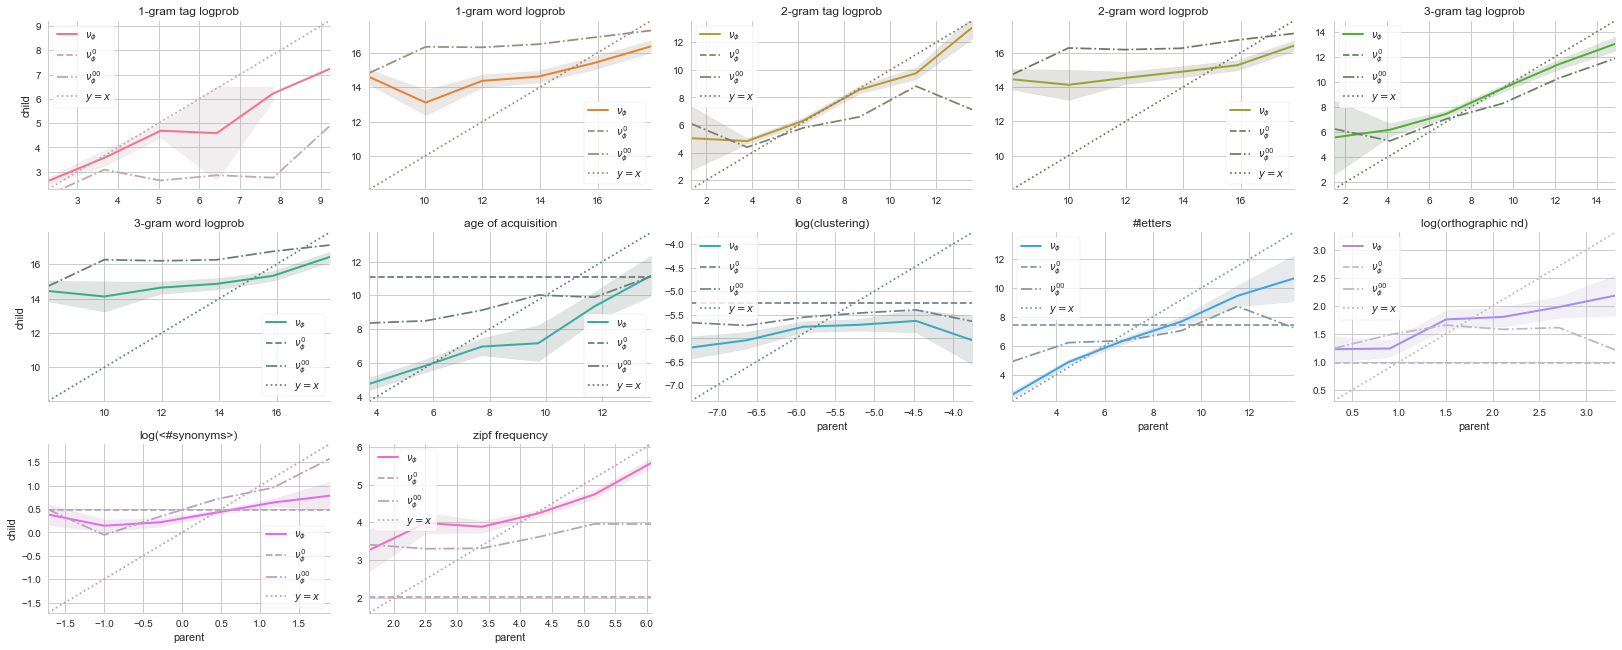

In [13]:
plot_grid(variations, features, plot_variation, 'parent', 'child',
          plot_kws={'binning': 6, 'quantiles': False})

### Paper figure

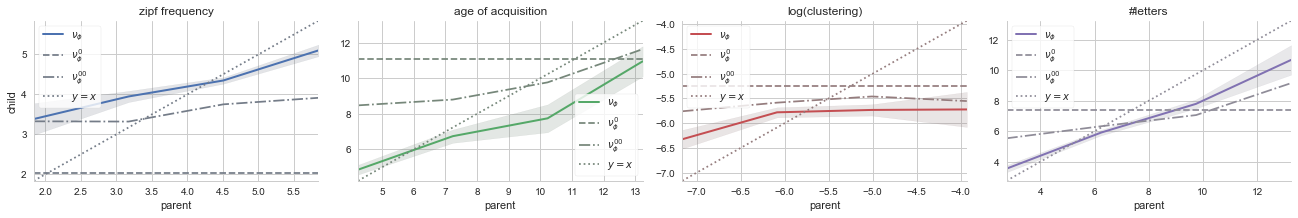

In [30]:
g = plot_grid(variations, paper_features, plot_variation, 'parent', 'child',
              plot_kws={'binning': 4, 'quantiles': False})
if SAVE_FIGURES:
    g.fig.savefig('feature-variation-rpl.png', dpi=300, bbox_inches='tight')

#### 2.2.2 Sentence-relative

No doc title found for 1_gram_tag-relmean
No doc title found for 1_gram_word-relmean
No doc title found for 2_gram_tag-relmean
No doc title found for 2_gram_word-relmean
No doc title found for 3_gram_tag-relmean
No doc title found for 3_gram_word-relmean
No doc title found for aoa-relmean
No doc title found for clustering-relmean
No doc title found for letters_count-relmean
No doc title found for orthographic_density-relmean
No doc title found for synonyms_count-relmean
No doc title found for zipf_frequency-relmean


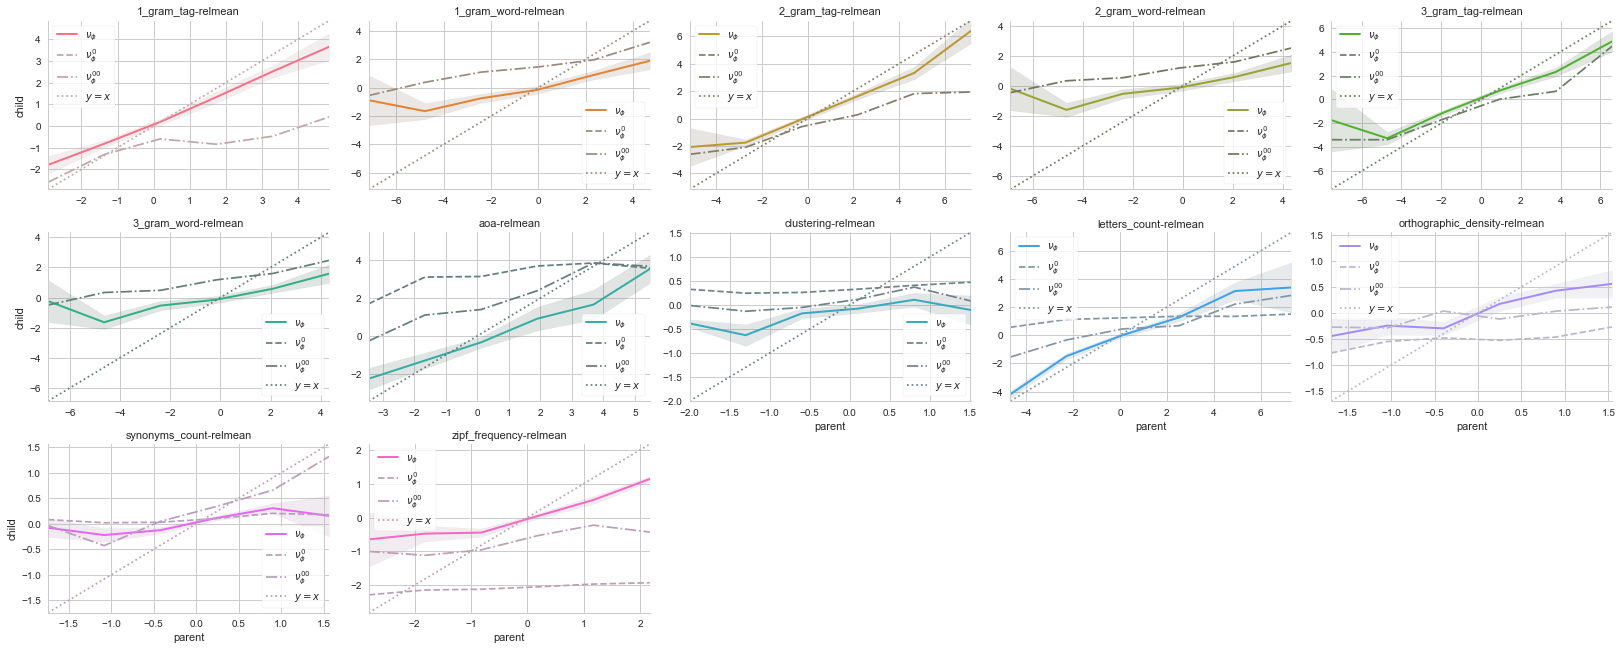

In [15]:
plot_grid(variations, features_rel, plot_variation, 'parent', 'child',
          plot_kws={'binning': 6, 'quantiles': False})

### 2.3 Feature variation on replacement, quantile bins

#### 2.3.1 Global

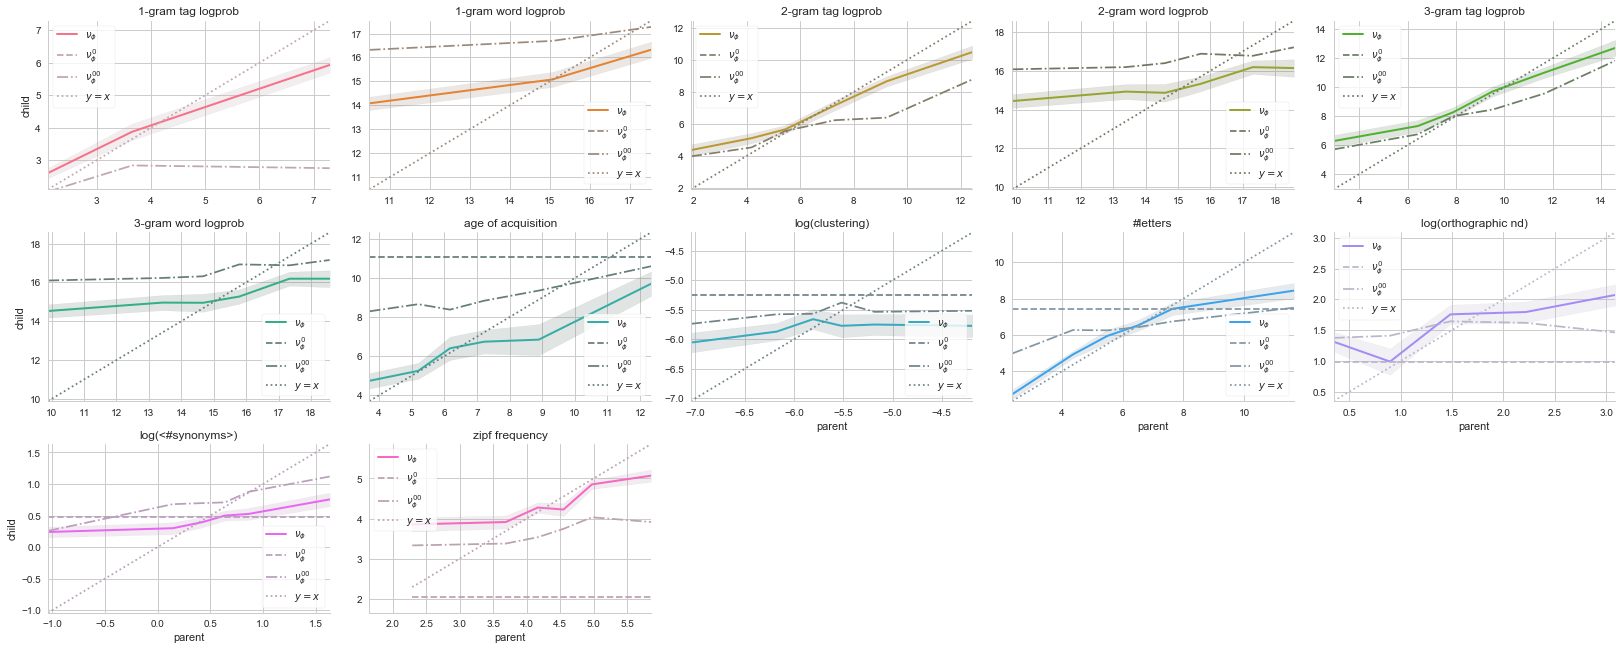

In [16]:
plot_grid(variations, features, plot_variation, 'parent', 'child',
          plot_kws={'binning': 6, 'quantiles': True})

#### 2.3.2 Sentence-relative

No doc title found for 1_gram_tag-relmean
No doc title found for 1_gram_word-relmean
No doc title found for 2_gram_tag-relmean
No doc title found for 2_gram_word-relmean
No doc title found for 3_gram_tag-relmean
No doc title found for 3_gram_word-relmean
No doc title found for aoa-relmean
No doc title found for clustering-relmean
No doc title found for letters_count-relmean
No doc title found for orthographic_density-relmean
No doc title found for synonyms_count-relmean
No doc title found for zipf_frequency-relmean


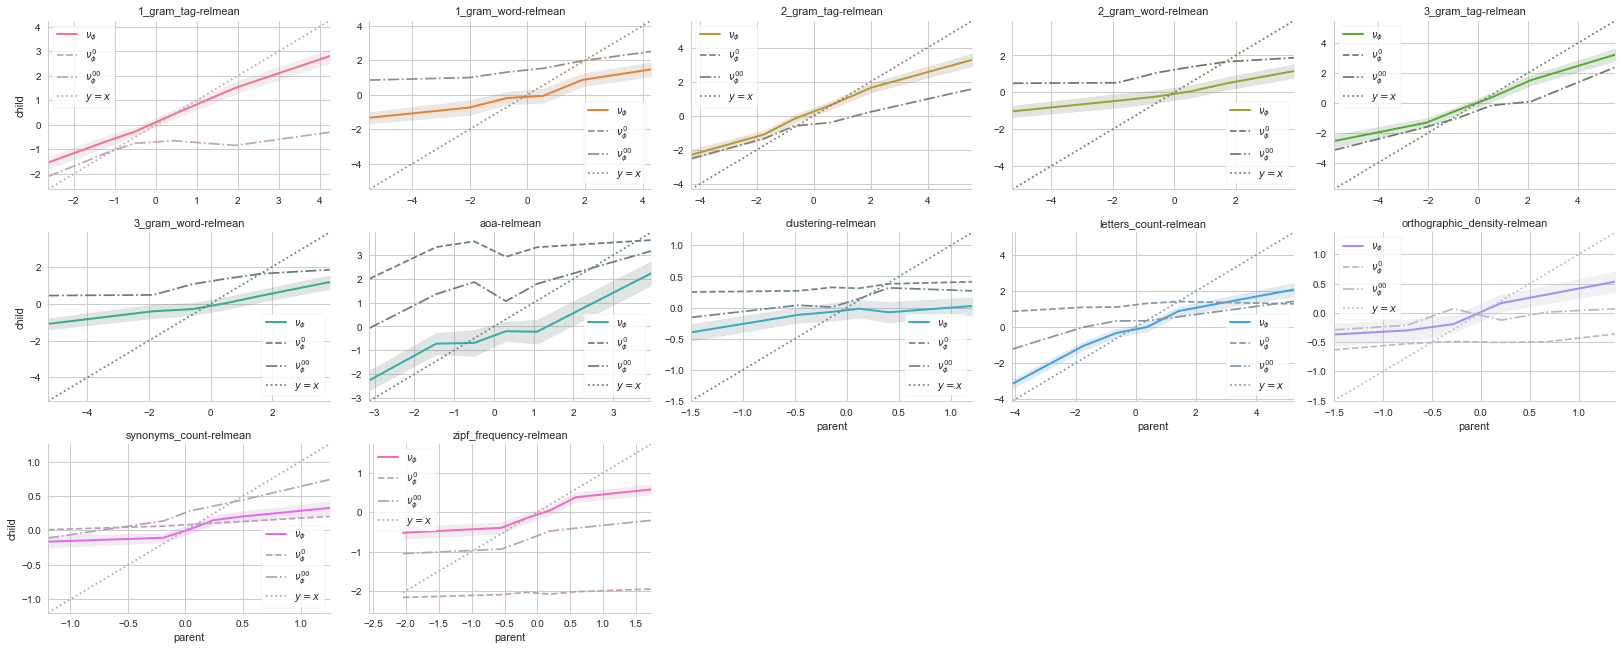

In [17]:
plot_grid(variations, features_rel, plot_variation, 'parent', 'child',
          plot_kws={'binning': 6, 'quantiles': True})

## 3 Cumulative transformation distance ~ POS

In [18]:
data1 = data[data.feature == 'aoa']

In [19]:
print("{:.1f}% of all replacements maintain the exact same POS"
      .format(100 * (data1.parent_pos == data1.child_pos).mean()))

62.7% of all replacements maintain the exact same POS


### 3.1 For all replacements

In [20]:
# Remove 99, the unknown POS
td_pos = data1[data1.parent_pos != 99]\
    .groupby('parent_pos')['distance', 'distance_h0n']\
    .aggregate({'mean': 'mean',
                'ci': lambda x: (stats.t.ppf(.975, len(x) - 1) * x.std(ddof=1)
                                 / np.sqrt(len(x)))})\
    .rename(index=lambda n: nlp.vocab.strings[int(n)])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)



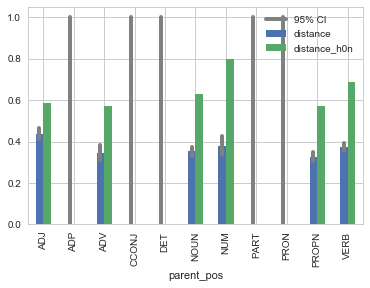

In [21]:
ax = td_pos.loc[:, 'mean'].plot(kind='bar')
for i, (_, distance, ci) in enumerate(td_pos[[('mean', 'distance'), ('ci', 'distance')]].itertuples()):
    ax.plot([i - .125, i - .125], [max(0, distance - ci), min(1, distance + ci)],
            lw=4, color='grey', label='95% CI' if i == 0 else None)
ax.legend()

### 3.2 For replacements that maintain the same POS

In [22]:
# Remove 99, the unknown POS
td_stablepos = data1[(data1.parent_pos == data1.child_pos) & (data1.parent_pos != 99)]\
    .groupby('parent_pos')['distance', 'distance_h0n']\
    .aggregate({'mean': 'mean',
                'ci': lambda x: (stats.t.ppf(.975, len(x) - 1) * x.std(ddof=1)
                                 / np.sqrt(len(x)))})\
    .rename(index=lambda n: nlp.vocab.strings[int(n)])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)



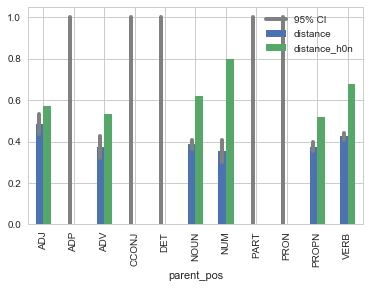

In [23]:
ax = td_stablepos.loc[:, 'mean'].plot(kind='bar')
for i, (_, distance, ci) in enumerate(td_stablepos[[('mean', 'distance'), ('ci', 'distance')]].itertuples()):
    ax.plot([i - .125, i - .125], [max(0, distance - ci), min(1, distance + ci)],
            lw=4, color='grey', label='95% CI' if i == 0 else None)
ax.legend()

## 4 Hypernym-hyponym rate

In [24]:
print("{:.1f}% of all replacements feature some sort of hypernym-hyponym relationship"
      .format(100 * data1.hypernym_related.mean()))
print("When restricting to same-POS replacements, that number is {:.1f}%"
      .format(100 * data1[data1.parent_pos == data1.child_pos].hypernym_related.mean()))
print("Whereas for different-POS replacements, it is {:.1f}%"
      .format(100 * data1[data1.parent_pos != data1.child_pos].hypernym_related.mean()))

25.6% of all replacements feature some sort of hypernym-hyponym relationship
When restricting to same-POS replacements, that number is 31.5%
Whereas for different-POS replacements, it is 15.6%


In [25]:
# Remove 99, the unknown POS
hh_pos = data1[data1.parent_pos != 99]\
    .groupby('parent_pos')['hypernym_rate']\
    .aggregate({'hypernym': 'sum',
                'related': lambda x: (data1[data1.parent_pos != 99].loc[x.index].hypernym_related).sum(),
                'total': 'size'})\
    .rename(index=lambda n: nlp.vocab.strings[int(n)])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.



In [26]:
hh_pos['unrelated'] = hh_pos.total - hh_pos.related
hh_pos['hyponym'] = hh_pos.related - hh_pos.hypernym

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/stats/proportion.py:212: RuntimeWarning: invalid value encountered in less
  if (counts < 0).any():



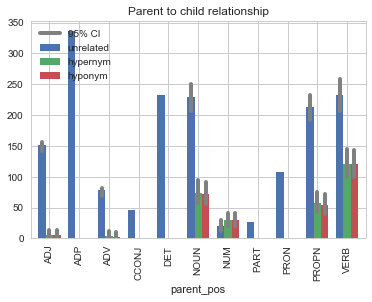

In [27]:
ax = hh_pos[['unrelated', 'hypernym', 'hyponym']].plot(kind='bar', width=.75)
for i, (_, unrelated, hypernym, hyponym) in enumerate(hh_pos[['unrelated', 'hypernym', 'hyponym']].itertuples()):
    total = unrelated + hypernym + hyponym
    cis = multinomial_proportions_confint(np.array([unrelated, hypernym, hyponym]).round(),
                                          method='goodman')
    ax.plot([i-.25, i-.25], cis[0] * total,
            lw=4, color='grey', label='95% CI' if i == 0 else None)
    ax.plot([i, i], cis[1] * total,
            lw=4, color='grey')
    ax.plot([i+.25, i+.25], cis[2] * total,
            lw=4, color='grey')
ax.set_title('Parent to child relationship')
ax.legend(loc='best')